In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [2]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision as tv
import numpy as np

In [3]:
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage()
print(t.__version__)

1.7.0


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import time

In [6]:
# 数据预处理，相当于提前定义了怎么处理数据：
# 因为读入的数据为numpy格式，所以我们要先将其转换为tensor格式，
# 然后对其进行归一化，有三个通道需要归一化，而第一个为均值，第二个为标准差
transform = transforms.Compose([
    transforms.ToTensor(), # 转为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 训练集
trainset = tv.datasets.CIFAR10(
    root='/kaggle/input/cifar10-python',
    train=True,
    download=False,
    transform=transform
)

# 迭代器
trainloader = t.utils.data.DataLoader(
    trainset,
    batch_size=32,
    shuffle=True,
    num_workers=16
)

# 测试集
testset = tv.datasets.CIFAR10(
    root='/kaggle/input/cifar10-python',
    train=False,
    download=False,
    transform=transform
)

# 迭代器
testloader = t.utils.data.DataLoader(
    trainset,
    batch_size=32,
    shuffle=False,
    num_workers=16
)
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

ship


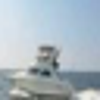

In [7]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))

cat       cat       frog       cat       horse       bird       cat       ship       frog       plane       car       dog       ship       dog       dog       truck       deer       cat       dog       horse       cat       truck       truck       plane       deer       dog       cat       deer       frog       bird       horse       truck


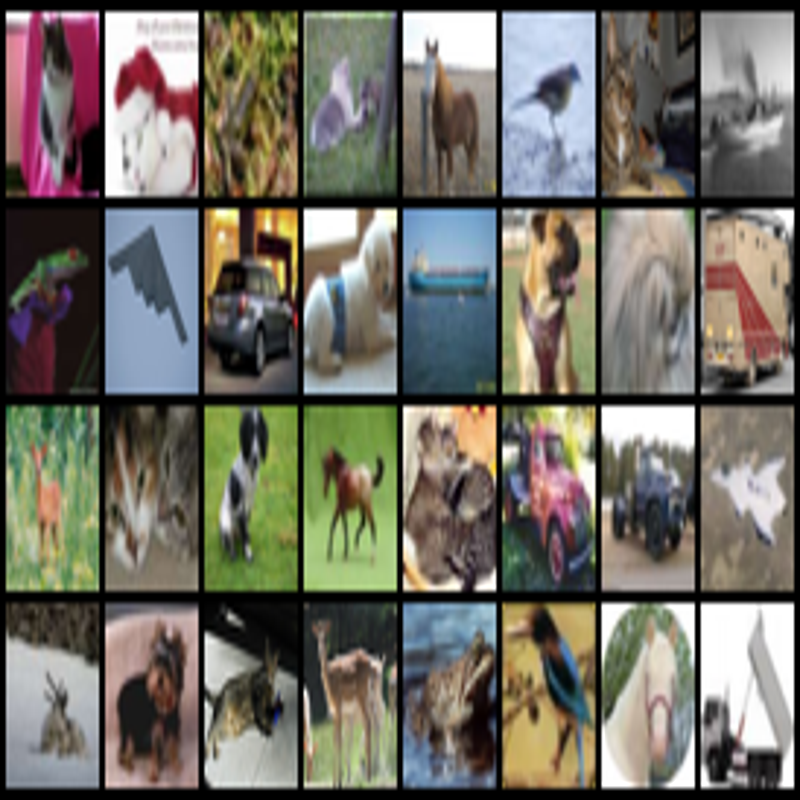

In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('       '.join(classes[labels]))
show(tv.utils.make_grid((images + 1) / 2)).resize((800, 800))

In [9]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return t.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.max_pool(x)
        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.max_pool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [10]:
googlenet = GoogLeNet()

In [11]:
for name, param in googlenet.named_parameters():
    print(name, param.size())

pre_layers.0.weight torch.Size([192, 3, 3, 3])
pre_layers.0.bias torch.Size([192])
pre_layers.1.weight torch.Size([192])
pre_layers.1.bias torch.Size([192])
a3.b1.0.weight torch.Size([64, 192, 1, 1])
a3.b1.0.bias torch.Size([64])
a3.b1.1.weight torch.Size([64])
a3.b1.1.bias torch.Size([64])
a3.b2.0.weight torch.Size([96, 192, 1, 1])
a3.b2.0.bias torch.Size([96])
a3.b2.1.weight torch.Size([96])
a3.b2.1.bias torch.Size([96])
a3.b2.3.weight torch.Size([128, 96, 3, 3])
a3.b2.3.bias torch.Size([128])
a3.b2.4.weight torch.Size([128])
a3.b2.4.bias torch.Size([128])
a3.b3.0.weight torch.Size([16, 192, 1, 1])
a3.b3.0.bias torch.Size([16])
a3.b3.1.weight torch.Size([16])
a3.b3.1.bias torch.Size([16])
a3.b3.3.weight torch.Size([32, 16, 3, 3])
a3.b3.3.bias torch.Size([32])
a3.b3.4.weight torch.Size([32])
a3.b3.4.bias torch.Size([32])
a3.b3.6.weight torch.Size([32, 32, 3, 3])
a3.b3.6.bias torch.Size([32])
a3.b3.7.weight torch.Size([32])
a3.b3.7.bias torch.Size([32])
a3.b4.1.weight torch.Size([32, 1

In [12]:
# 定义优化器和损失函数
optimizer = optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [13]:
# move the input and model to GPU for speed if available
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

In [14]:
googlenet.to(device)

GoogLeNet(
  (pre_layers): Sequential(
    (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (a3): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, m

In [15]:
print(device)

cuda:0


In [16]:
googlenet.to(device)

GoogLeNet(
  (pre_layers): Sequential(
    (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (a3): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, m

In [17]:
# 训练网络

all_time =[]
losses = []

for epoch in range(7):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = googlenet(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time
        all_time.append(time_taken)
        
        # print statistics
        running_loss += loss.item()
        if i % 300 == 299:    # print every 300 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 300))
            print('Time:',time_taken)
            losses.append(running_loss)
            running_loss = 0.0

[1,   300] loss: 1.772
Time: 35.53966188430786
[1,   600] loss: 1.400
Time: 68.97581052780151
[1,   900] loss: 1.235
Time: 102.38541579246521
[1,  1200] loss: 1.095
Time: 135.88586115837097
[1,  1500] loss: 1.007
Time: 168.89834547042847
[2,   300] loss: 0.888
Time: 34.47867274284363
[2,   600] loss: 0.866
Time: 67.68035101890564
[2,   900] loss: 0.807
Time: 101.03331780433655
[2,  1200] loss: 0.757
Time: 134.2492446899414
[2,  1500] loss: 0.731
Time: 167.61242580413818
[3,   300] loss: 0.619
Time: 34.34554314613342
[3,   600] loss: 0.600
Time: 67.79946255683899
[3,   900] loss: 0.592
Time: 101.0586416721344
[3,  1200] loss: 0.582
Time: 134.4924943447113
[3,  1500] loss: 0.578
Time: 168.2558388710022
[4,   300] loss: 0.445
Time: 34.41655969619751
[4,   600] loss: 0.481
Time: 67.96375370025635
[4,   900] loss: 0.461
Time: 101.57607102394104
[4,  1200] loss: 0.456
Time: 134.7237091064453
[4,  1500] loss: 0.458
Time: 168.2217824459076
[5,   300] loss: 0.335
Time: 33.968655586242676
[5,   

TypeError: unsupported operand type(s) for /: 'list' and 'int'

(0.0, 1.822036327123642)

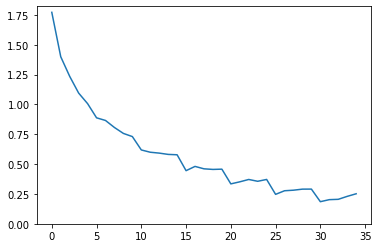

In [25]:
# 误差的图像
plt.plot(np.array(losses) / 300)
plt.ylim(0, max(np.array(losses) / 300) + 0.05)

In [18]:
print(f'Finished Training of GoogLeNet, time_spent: {sum(all_time) / 1000}s')

Finished Training of GoogLeNet, time_spent: 963.6880036702156s


In [21]:
#Testing Accuracy
correct = 0
total = 0
with t.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = googlenet(images)
        _, predicted = t.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 94.63 %


In [22]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with t.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = googlenet(images)
        _, predicted = t.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 94 %
Accuracy of   car : 96 %
Accuracy of  bird : 93 %
Accuracy of   cat : 89 %
Accuracy of  deer : 93 %
Accuracy of   dog : 89 %
Accuracy of  frog : 96 %
Accuracy of horse : 94 %
Accuracy of  ship : 98 %
Accuracy of truck : 97 %


In [23]:
#Verifying average accuracy of the network
avg = 0
for i in range(10):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  94.44109502443627
